In [1]:
import pandas as pd
from pymongo import MongoClient
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
MONGO_URI = "mongodb://my-mongo-db:27017/"

In [3]:
def get_mongo_data_to_pandas(db_name, collection_name):
    """
    Connects to MongoDB, fetches all documents from a collection,
    and returns them as a Pandas DataFrame.

    Args:
        db_name (str): The name of the database to connect to.
        collection_name (str): The name of the collection to read from.

    Returns:
        pandas.DataFrame: A DataFrame containing the data from the collection,
                          or None if an error occurs.
    """
    print(f"Connecting to MongoDB at {MONGO_URI}...")
    try:
        # Establish a connection to the MongoDB server
        client = MongoClient(MONGO_URI)
        db = client[db_name]
        collection = db[collection_name]

        print(f"Fetching data from '{db_name}.{collection_name}'...")
        # Fetch all documents from the collection
        cursor = collection.find()

        # Convert the cursor to a list of dictionaries
        data_list = list(cursor)

        # close the connection
        client.close()

        if not data_list:
            print("Warning: No data found in the collection.")
            return pd.DataFrame() # Return an empty DataFrame

        # Create a Pandas DataFrame from the list of dictionaries
        # The '_id' column from MongoDB is  dropped as it's not needed for analysis.
        df = pd.DataFrame(data_list).drop(columns=['_id'], errors='ignore')
        print("Successfully loaded data into Pandas DataFrame.")
        return df

    except Exception as e:
        print(f"An error occurred while connecting to MongoDB: {e}")
        return None

In [4]:
#Ridership data
DB_NAME = "ny_transit_data"
COLLECTION_NAME = "ridership"
pandas_df = get_mongo_data_to_pandas(DB_NAME, COLLECTION_NAME)

Connecting to MongoDB at mongodb://my-mongo-db:27017/...
Fetching data from 'ny_transit_data.ridership'...
Successfully loaded data into Pandas DataFrame.


In [5]:
print("\n--- Pandas DataFrame Head ---")
print(pandas_df.head())
print("\n--- Pandas DataFrame Info ---")
pandas_df.info()


--- Pandas DataFrame Head ---
  transit_timestamp transit_mode station_complex_id         station_complex  \
0        2024-12-01         tram              TRAM2  RI Tramway (Roosevelt)   
1        2024-12-01         tram              TRAM1  RI Tramway (Manhattan)   
2        2024-12-01         tram              TRAM1  RI Tramway (Manhattan)   
3        2024-12-01         tram              TRAM2  RI Tramway (Roosevelt)   
4        2024-12-01         tram              TRAM1  RI Tramway (Manhattan)   

     borough payment_method               fare_class_category  ridership  \
0  Manhattan      metrocard             Metrocard - Full Fare        6.0   
1  Manhattan      metrocard             Metrocard - Full Fare        8.0   
2  Manhattan      metrocard       Metrocard - Unlimited 7-Day        4.0   
3  Manhattan      metrocard  Metrocard - Seniors & Disability        1.0   
4  Manhattan           omny                  OMNY - Full Fare       21.0   

   transfers   latitude  longitude  \

In [6]:
# Weather Data
DB_NAME = 'ny_transit_data'
COLLECTION_NAME = 'weather_data'
pandas_weather_df = get_mongo_data_to_pandas(DB_NAME, COLLECTION_NAME)
print("\n--- Pandas Weather DataFrame Head ---")
print(pandas_weather_df.head())
print("\n--- Pandas Weather DataFrame Info ---")
pandas_weather_df.info()

Connecting to MongoDB at mongodb://my-mongo-db:27017/...
Fetching data from 'ny_transit_data.weather_data'...
Successfully loaded data into Pandas DataFrame.

--- Pandas Weather DataFrame Head ---
                    dt_nyc          dt   id    main       description icon  \
0  2024-09-01 00:00:00 EDT  1725163200  802  Clouds  scattered clouds  03n   
1  2024-09-01 01:00:00 EDT  1725166800  800   Clear         clear sky  01n   
2  2024-09-01 02:00:00 EDT  1725170400  802  Clouds  scattered clouds  03n   
3  2024-09-01 03:00:00 EDT  1725174000  804  Clouds   overcast clouds  04n   
4  2024-09-01 04:00:00 EDT  1725177600  804  Clouds   overcast clouds  04n   

   main.temp  main.feels_like  main.pressure  main.humidity  wind.speed  \
0     295.84           296.41           1014             86        3.60   
1     295.70           296.26           1014             86        3.09   
2     295.47           296.03           1014             87        3.09   
3     295.64           296.16     

In [7]:
pandas_weather_df['main'].unique()

array(['Clouds', 'Clear', 'Haze', 'Drizzle', 'Smoke', 'Mist', 'Rain',
       'Fog', 'Snow', 'Thunderstorm'], dtype=object)

In [8]:
print("\nInitializing SparkSession...")
try:
    spark = SparkSession.builder \
        .appName("MongoToSpark") \
        .config("spark.driver.memory", "16g") \
        .getOrCreate()
    print("SparkSession initialized successfully.")
except Exception as e:
    print(f"Failed to initialize SparkSession: {e}")
spark


Initializing SparkSession...
SparkSession initialized successfully.


In [9]:
spark_df = spark.createDataFrame(pandas_df)

print("Conversion successful!")

# --- Step 4: Show results from Spark DataFrame ---
print("\n--- Spark DataFrame (Top 20 Rows) ---")
spark_df.show()

print("\n--- Spark DataFrame Schema ---")
spark_df.printSchema()

Conversion successful!

--- Spark DataFrame (Top 20 Rows) ---
+-------------------+------------+------------------+--------------------+---------+--------------+--------------------+---------+---------+---------+----------+--------------------+
|  transit_timestamp|transit_mode|station_complex_id|     station_complex|  borough|payment_method| fare_class_category|ridership|transfers| latitude| longitude|        georeference|
+-------------------+------------+------------------+--------------------+---------+--------------+--------------------+---------+---------+---------+----------+--------------------+
|2024-12-01 00:00:00|        tram|             TRAM2|RI Tramway (Roose...|Manhattan|     metrocard|Metrocard - Full ...|      6.0|      0.0| 40.75734| -73.95412|{coordinates -> [...|
|2024-12-01 00:00:00|        tram|             TRAM1|RI Tramway (Manha...|Manhattan|     metrocard|Metrocard - Full ...|      8.0|      3.0|40.761337| -73.96416|{coordinates -> [...|
|2024-12-01 00:00:00|  

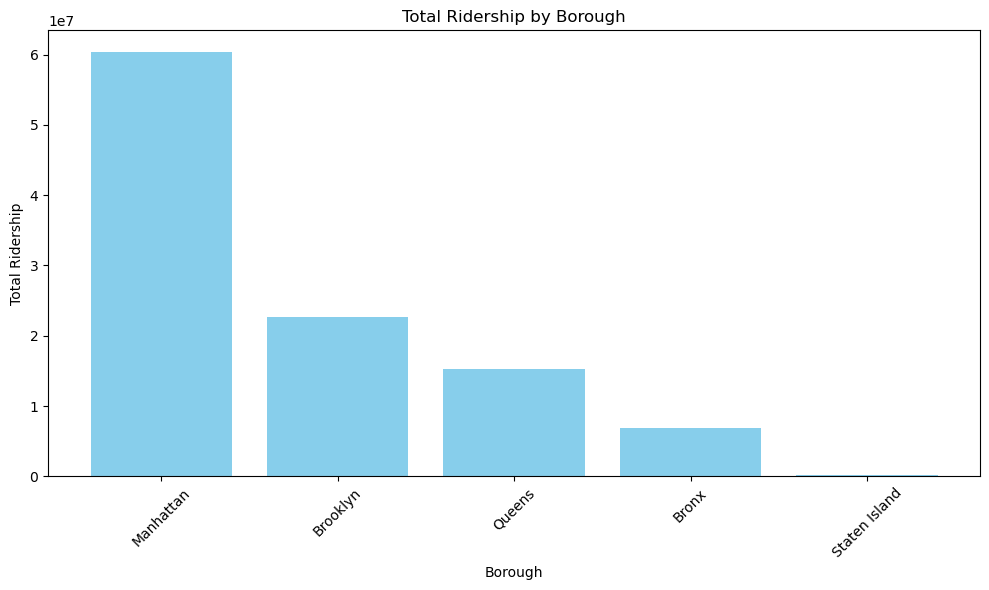

<Figure size 640x480 with 0 Axes>

In [16]:

# Aggregate the data in PySpark
borough_ridership = spark_df.groupBy("borough").agg(F.sum("ridership").alias("total_ridership")).orderBy("total_ridership", ascending=False)

# Convert the aggregated Spark DataFrame to a Pandas DataFrame
borough_ridership_pd = borough_ridership.toPandas()

# Generate the plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(borough_ridership_pd["borough"], borough_ridership_pd["total_ridership"], color='skyblue')
plt.xlabel("Borough")
plt.ylabel("Total Ridership")
plt.title("Total Ridership by Borough")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save the plot to a file
plt.savefig("./plots/ridership_by_borough.png")

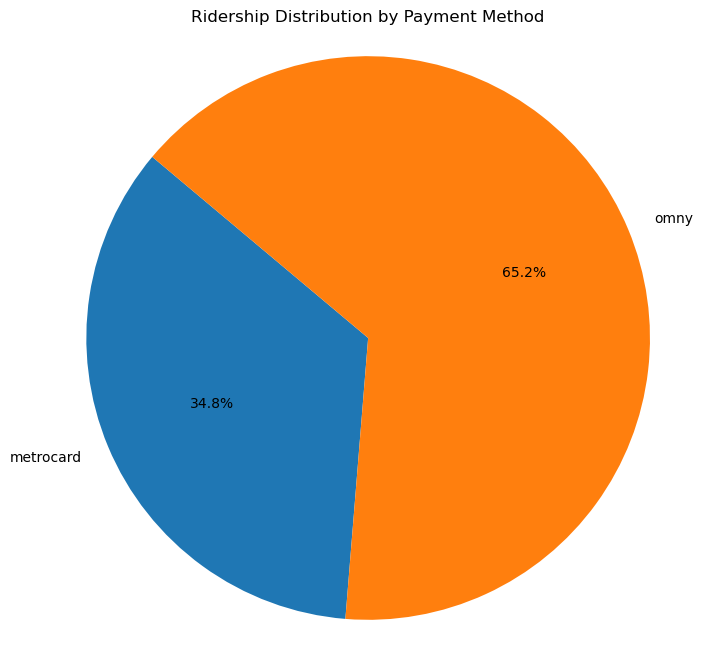

<Figure size 640x480 with 0 Axes>

In [17]:
# Ridership group by payment method
payment_method_ridership = spark_df.groupBy("payment_method").agg(F.sum("ridership").alias("total_ridership"))

# 2. Convert the Spark DataFrame to a Pandas DataFrame
payment_method_ridership_pd = payment_method_ridership.toPandas()

# 3. Generate the plot using Matplotlib
plt.figure(figsize=(8, 8))
plt.pie(payment_method_ridership_pd["total_ridership"], labels=payment_method_ridership_pd["payment_method"], autopct='%1.1f%%', startangle=140)
plt.title("Ridership Distribution by Payment Method")
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Save the plot to a file
plt.savefig("./plots/ridership_by_payment_method.png")

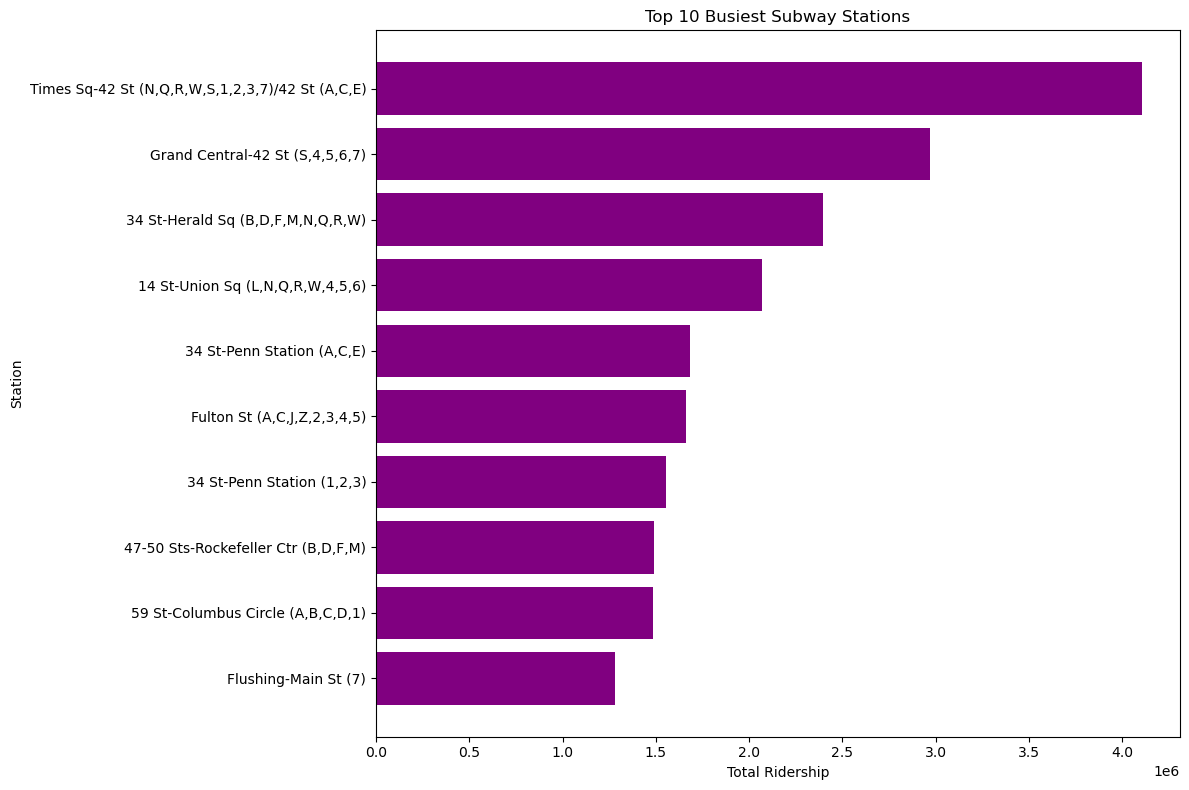

<Figure size 640x480 with 0 Axes>

In [18]:
top_stations = spark_df.groupBy("station_complex") \
                       .agg(F.sum("ridership").alias("total_ridership")) \
                       .orderBy(F.col("total_ridership").desc()) \
                       .limit(10)

# Convert  a Pandas DataFrame
top_stations_pd = top_stations.toPandas()

# Generate the plot using Matplotlib
plt.figure(figsize=(12, 8))
plt.barh(top_stations_pd["station_complex"], top_stations_pd["total_ridership"], color='purple')
plt.xlabel("Total Ridership")
plt.ylabel("Station")
plt.title("Top 10 Busiest Subway Stations")
plt.gca().invert_yaxis() # To display the station with the highest ridership at the top
plt.tight_layout()
plt.show()

# Save the plot to a file
plt.savefig("./plots/top_10_busiest_stations.png")

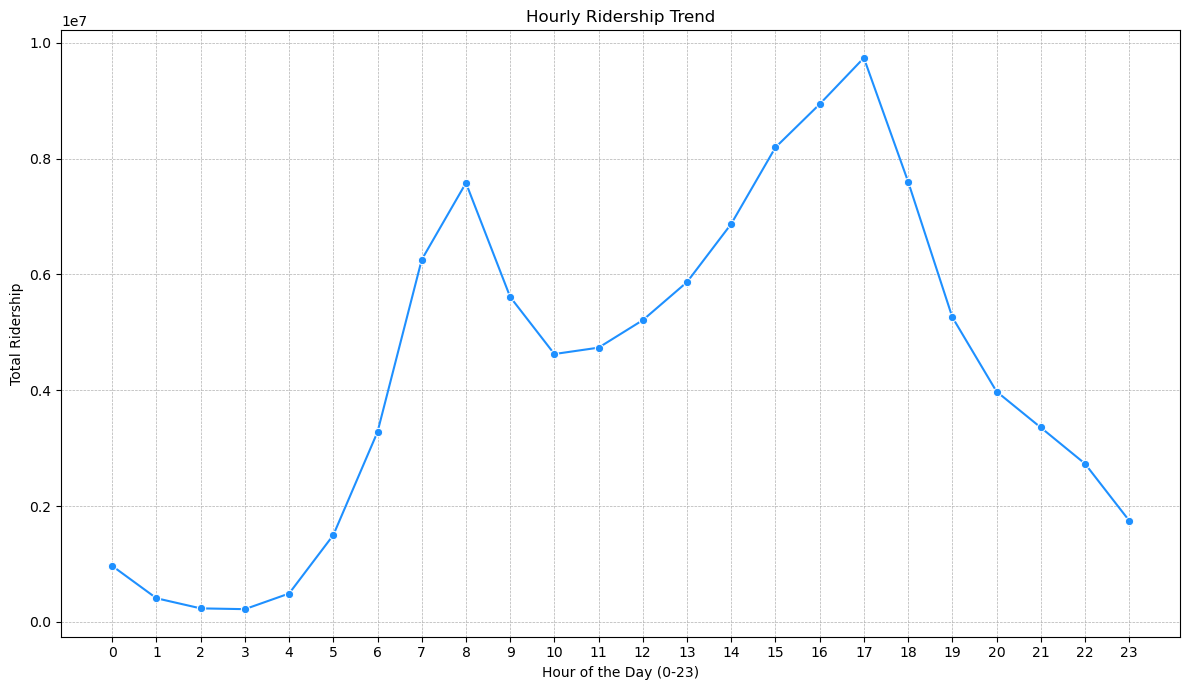

<Figure size 640x480 with 0 Axes>

In [19]:
df_with_hour = spark_df.withColumn("hour_of_day", F.hour(F.col("transit_timestamp")))

# ridership by the hour of the day
hourly_ridership = df_with_hour.groupBy("hour_of_day") \
                               .agg(F.sum("ridership").alias("total_ridership")) \
                               .orderBy("hour_of_day")

# Convert to a Pandas DataFrame
hourly_ridership_pd = hourly_ridership.toPandas()

# Generate the plot using Matplotlib and Seaborn for a nicer look
plt.figure(figsize=(12, 7))
sns.lineplot(data=hourly_ridership_pd, x="hour_of_day", y="total_ridership", marker='o', color='dodgerblue')
plt.xlabel("Hour of the Day (0-23)")
plt.ylabel("Total Ridership")
plt.title("Hourly Ridership Trend")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(range(0, 24)) # Ensure all hours are marked on the x-axis
plt.tight_layout()
plt.show()

# Save the plot to a file
plt.savefig("./plots/hourly_ridership_trend.png")

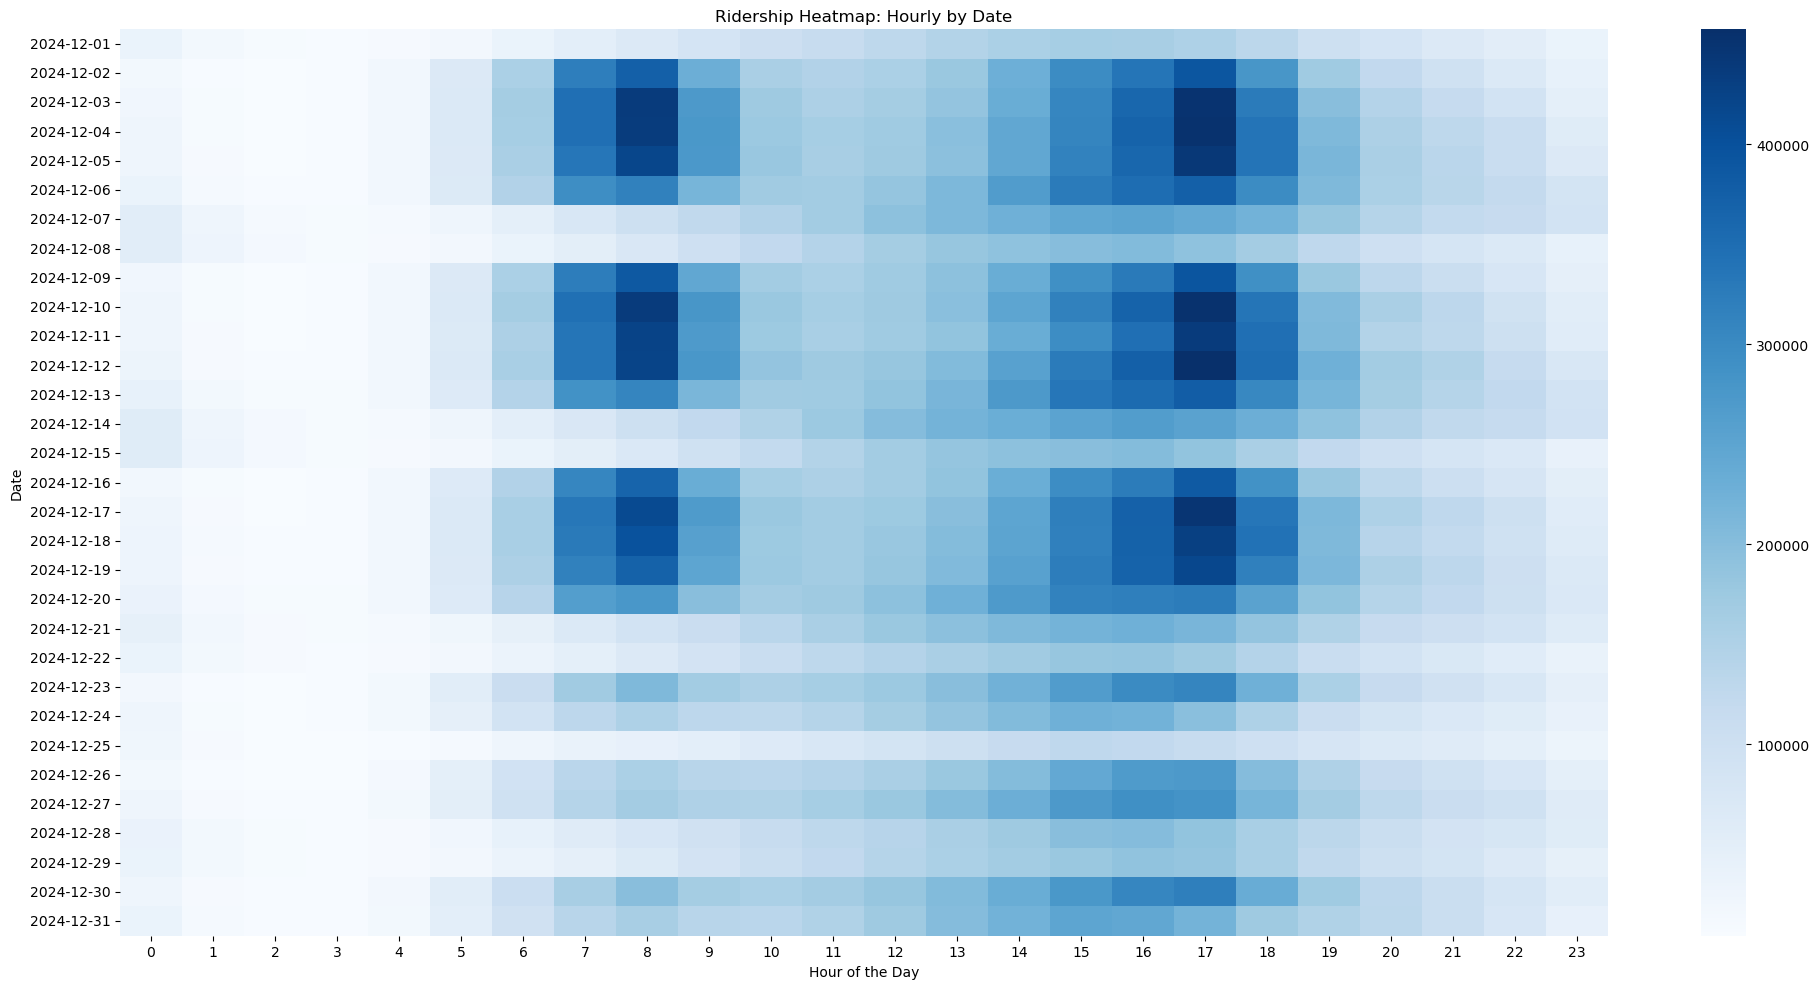

<Figure size 640x480 with 0 Axes>

In [20]:
# Extract the date and hour from the transit_timestamp column
df_with_date_hour = spark_df.withColumn("date", F.to_date(F.col("transit_timestamp"))) \
                       .withColumn("hour_of_day", F.hour(F.col("transit_timestamp")))

# Group by date and hour to aggregate ridership
hourly_ridership_by_date = df_with_date_hour.groupBy("date", "hour_of_day") \
                                            .agg(F.sum("ridership").alias("total_ridership"))

# Pivot the data to create a matrix with dates as rows and hours as columns
# This format is required for the heatmap visualization.
heatmap_data = hourly_ridership_by_date.groupBy("date") \
                                       .pivot("hour_of_day") \
                                       .sum("total_ridership") \
                                       .orderBy("date")

# Fill any null values that might result from the pivot operation (if some hours had no ridership)
heatmap_data = heatmap_data.fillna(0)

# Convert the pivoted Spark DataFrame to a Pandas DataFrame for plotting
heatmap_pd = heatmap_data.toPandas()

# Set the 'date' column as the index of the Pandas DataFrame
heatmap_pd = heatmap_pd.set_index('date')

# Generate the heatmap using Seaborn
plt.figure(figsize=(20, 10)) # Adjust size as needed based on the number of dates
sns.heatmap(heatmap_pd, cmap="Blues", annot=False) # 'viridis' is a good color map for this
plt.title("Ridership Heatmap: Hourly by Date")
plt.xlabel("Hour of the Day")
plt.ylabel("Date")
plt.tight_layout()
plt.show()

# Save the plot to a file
plt.savefig("./plots/ridership_heatmap.png")

In [21]:
spark_weather_df = spark.createDataFrame(pandas_weather_df)

print("Conversion successful!")

# --- Step 4: Show results from Spark Weather DataFrame ---
print("\n--- Spark DataFrame (Top 20 Rows) ---")
spark_weather_df.show()

print("\n--- Spark Weather DataFrame Schema ---")
spark_weather_df.printSchema()

Conversion successful!

--- Spark DataFrame (Top 20 Rows) ---
+--------------------+----------+---+-------+--------------------+----+---------+---------------+-------------+-------------+----------+--------+---------+
|              dt_nyc|        dt| id|   main|         description|icon|main.temp|main.feels_like|main.pressure|main.humidity|wind.speed|wind.deg|wind.gust|
+--------------------+----------+---+-------+--------------------+----+---------+---------------+-------------+-------------+----------+--------+---------+
|2024-09-01 00:00:...|1725163200|802| Clouds|    scattered clouds| 03n|   295.84|         296.41|         1014|           86|       3.6|     180|      NaN|
|2024-09-01 01:00:...|1725166800|800|  Clear|           clear sky| 01n|    295.7|         296.26|         1014|           86|      3.09|     180|      NaN|
|2024-09-01 02:00:...|1725170400|802| Clouds|    scattered clouds| 03n|   295.47|         296.03|         1014|           87|      3.09|     190|      NaN|
|2

In [22]:
def classify_weather(weather_condition):
    """
    Classifies a weather condition string as 'Good', 'Bad', or 'Potentially Bad'.
    
    Args:
        weather_condition (str): The weather condition to classify (e.g., 'Clear', 'Rain').
        
    Returns:
        str: The classification of the weather.
    """
    good_weather = ['Clear', 'Clouds']
    bad_weather = ['Rain', 'Thunderstorm', 'Snow', 'Drizzle','Fog', 'Mist', 'Haze', 'Smoke']

    if weather_condition in good_weather:
        return 'Good'
    elif weather_condition in bad_weather:
        return 'Bad'
    else:
        return 'Unknown'

In [27]:
weather_udf = F.udf(classify_weather, StringType())

# We use withColumn() to add a new column named 'weather_quality'.
# The new column's values are generated by passing the 'main' column to our UDF.
classified_weather_df = spark_weather_df.withColumn(
    "weather_quality", 
    weather_udf(F.col("main"))
)
classified_weather_df.show()

+--------------------+----------+---+-------+--------------------+----+---------+---------------+-------------+-------------+----------+--------+---------+---------------+
|              dt_nyc|        dt| id|   main|         description|icon|main.temp|main.feels_like|main.pressure|main.humidity|wind.speed|wind.deg|wind.gust|weather_quality|
+--------------------+----------+---+-------+--------------------+----+---------+---------------+-------------+-------------+----------+--------+---------+---------------+
|2024-09-01 00:00:...|1725163200|802| Clouds|    scattered clouds| 03n|   295.84|         296.41|         1014|           86|       3.6|     180|      NaN|           Good|
|2024-09-01 01:00:...|1725166800|800|  Clear|           clear sky| 01n|    295.7|         296.26|         1014|           86|      3.09|     180|      NaN|           Good|
|2024-09-01 02:00:...|1725170400|802| Clouds|    scattered clouds| 03n|   295.47|         296.03|         1014|           87|      3.09|    